In [2]:
import torch
import sys, os
sys.path.append('../')
import matplotlib.pyplot as plt
import seaborn as sns

import json
import pandas as pd
import numpy as np
import glob

## Task 1: maligant classifcation 
- FFDM: Linear classifier / locality-attention + linear classfier 
- US: MIL-attention + linear classfier 

In [44]:
sns.set_context("talk")
sns.set_style("whitegrid")
def plot_auc_learning_curve(logs, text):

    plt.figure(figsize=(8, 5))
    logs[logs['mode']=='val']['head4_auc'].plot(marker='o', use_index=False, alpha=0.6)

    highest = logs[logs['mode']=='val']['head4_auc'].max()
    epoch = logs[logs['mode']=='val']['head4_auc'].argmax()

    plt.scatter(y=highest, x=epoch, marker='*', color='r', s=300)
    plt.text(y=highest-0.001, x=epoch-1, text=f'highest AUC={highest:1.3f}', s=100)

    plt.ylabel('Test AUC '+text)
    plt.xlabel('epoch')
    plt.plot()

In [4]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

In [5]:
def get_lastest_runlogs(save_path, run_path):
    """gather the log of the lastest run and return log as data frame."""
    try:
        file = sorted(glob.glob(os.path.join(save_path, run_path, '*.json')))[-1]
        with open(file) as f:
            lines = f.readlines()[1:]
        logs = pd.DataFrame([json.loads(line) for line in lines])
    except:
        print(save_path, run_path)
        raise FileNotFoundError

    return logs

def get_comparison_table(modal_cls, model_path, exp_prefix, weight_init):
    performance = []
    for modal in modal_cls:
        for path in model_path:
            for exp in exp_prefix:
                for winit in weight_init:
                    try:
                        logs = get_lastest_runlogs(save_path, f'{modal}/{path}/{exp}{winit}')
                    
                        loss, auc = logs[logs['mode']=='val'].head4_loss.min(), logs[logs['mode']=='val'].head4_auc.max()

                        performance.append({'modal': modal, 'pretrain-exp': path,
                            'exp': exp, 
                            'weight init': winit.split('_')[-1] if winit!='' else 'cross-modal swav', 
                            'loss': loss, 'auc': auc})
                    except FileNotFoundError:
                        pass

    return pd.DataFrame(performance)



### FFDM:

#### Ablation study on the classifier complexity: Linear V.S. Linear +locality-attention

In [15]:
modal_cls = ['ffdm']
model_path = ['20220411_ffdm_latest.pth']
exp_prefix = ['balanced', 'locality_atten']
weight_init = ['', '_imagenet', '_randominit']

performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

,modal,pretrain-exp,exp,weight init,loss,auc
0,ffdm,20220411_ffdm_latest.pth,balanced,cross-modal swav,0.51060,0.57232
1,ffdm,20220411_ffdm_latest.pth,balanced,imagenet,0.51911,0.55301
2,ffdm,20220411_ffdm_latest.pth,balanced,randominit,0.54338,0.47133
3,ffdm,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.51121,0.59027
4,ffdm,20220411_ffdm_latest.pth,locality_atten,imagenet,0.51882,0.56775
5,ffdm,20220411_ffdm_latest.pth,locality_atten,randominit,0.51670,0.46325


(0.4, 0.65)

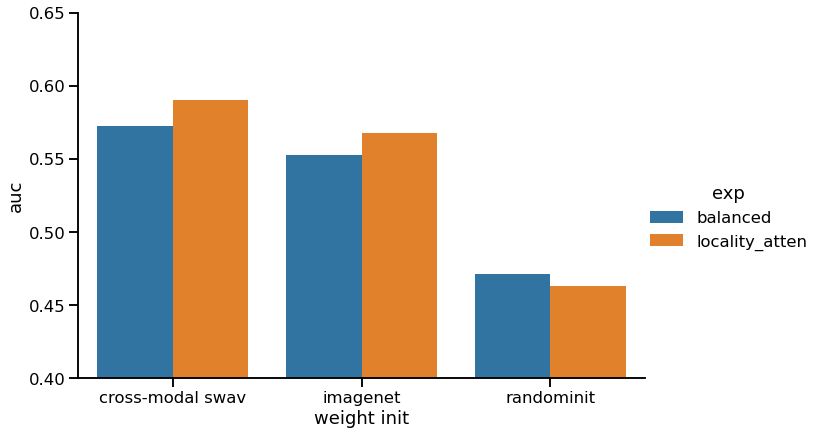

In [25]:
sns.set_context('talk')
sns.catplot(data=performance, y='auc', x='weight init', hue='exp', kind="bar", height=6, aspect=1.5)
plt.ylim(0.4, 0.65)

#### Ablantion study on the datasampler: fixed 4000 samples V.S. random negative samples per epoch

Basic configuration: Linear classifier +  locality-attention

In [26]:
modal_cls = ['ffdm', 'ffdm_fixed_datasampler']
model_path = ['20220411_ffdm_latest.pth']
exp_prefix = ['locality_atten']
weight_init = ['', '_imagenet', '_randominit']

performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

,modal,pretrain-exp,exp,weight init,loss,auc
0,ffdm,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.51121,0.59027
1,ffdm,20220411_ffdm_latest.pth,locality_atten,imagenet,0.51882,0.56775
2,ffdm,20220411_ffdm_latest.pth,locality_atten,randominit,0.51670,0.46325
3,ffdm_fixed_datasampler,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.50497,0.57900
4,ffdm_fixed_datasampler,20220411_ffdm_latest.pth,locality_atten,imagenet,0.50243,0.57807
5,ffdm_fixed_datasampler,20220411_ffdm_latest.pth,locality_atten,randominit,0.51483,0.46700


#### Ablantion study on the FFDM resolution: 736x480 V.S. 1472x960

NameError: name 'logs' is not defined

In [27]:
modal_cls = ['ffdm', 'ffdm_highresolution.py']
model_path = ['20220411_ffdm_latest.pth', 'ffdm_latest.pth']
exp_prefix = ['locality_atten']
weight_init = ['']

performance = get_comparison_table(modal_cls, model_path, exp_prefix, weight_init)
performance

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm/ffdm_latest.pth/locality_atten
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ ffdm_highresolution.py/20220411_ffdm_latest.pth/locality_atten


,modal,pretrain-exp,exp,weight init,loss,auc
0,ffdm,20220411_ffdm_latest.pth,locality_atten,cross-modal swav,0.51121,0.59027
1,ffdm_highresolution.py,ffdm_latest.pth,locality_atten,cross-modal swav,0.50453,0.58517


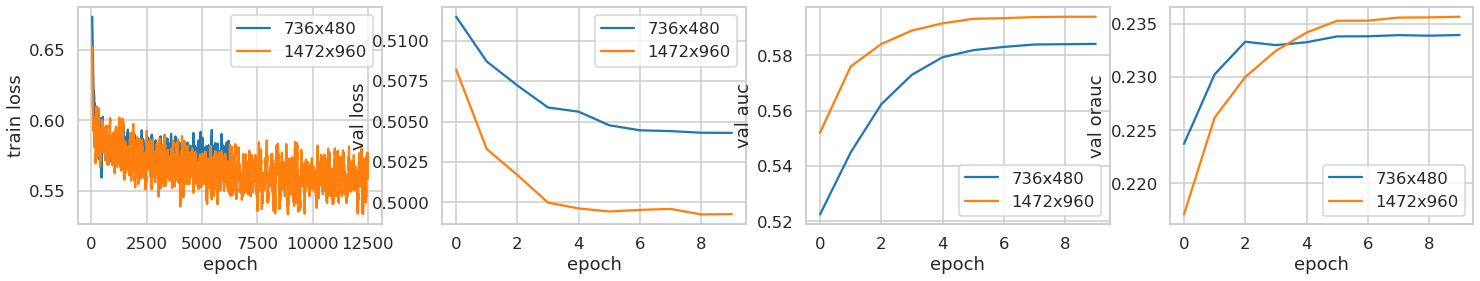

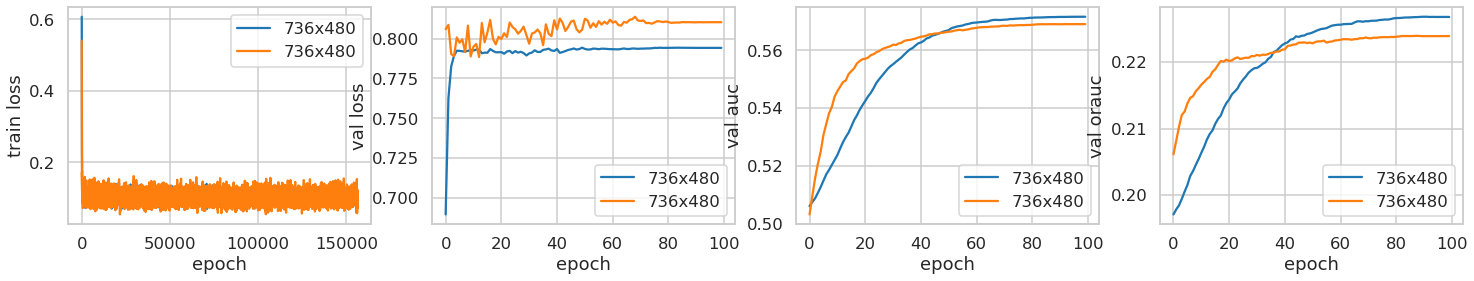

In [50]:
def learning_curves_comparsion(modal_cls, file_prefixes, titles): 
    fig, axs = plt.subplots(1, 4, figsize=(25, 4))
    for (modal, path, exp, winit), title  in zip(file_prefixes, titles):
        logs = get_lastest_runlogs(save_path, f'{modal}/{path}/{exp}{winit}')
        logs[logs['mode']=='train'].loss.rolling(50).mean().plot(
            use_index=False, label=title, ax=axs[0])

        axs[0].set_ylabel('train loss')
        axs[0].set_xlabel('epoch')
        axs[0].legend()

        logs[logs['mode']=='val'].head4_loss.plot(
            use_index=False, label=title, ax=axs[1])

        axs[1].set_ylabel('val loss')
        axs[1].set_xlabel('epoch')
        axs[1].legend()

        logs[logs['mode']=='val'].head4_auc.plot(
            use_index=False, label=title, ax=axs[2])

        axs[2].set_ylabel('val auc')
        axs[2].set_xlabel('epoch')
        axs[2].legend()
        if 'head4_prauc' in logs:

            logs[logs['mode']=='val'].head4_prauc.plot(
                use_index=False, label=title, ax=axs[3])

        axs[3].set_ylabel('val orauc')
        axs[3].set_xlabel('epoch')
        axs[3].legend()

    plt.show()


file_prefixes = [('ffdm', '20220411_ffdm_latest.pth', 'ablation_reso', ''), 
                 ('ffdm_highresolution', 'ffdm_latest.pth', 'ablation_reso', '')]
titles = ['736x480', '1472x960']
learning_curves_comparsion(modal_cls, file_prefixes, titles)



file_prefixes = [('ffdm_biopsied_sampler', '20220411_ffdm_latest.pth', 'locality_atten', ''),
                 ('ffdm_highresolution', 'ffdm_latest.pth', 'biopsied_sampler', ''),]
titles = ['736x480', '736x480', '1472x960', '1472x960']
learning_curves_comparsion(modal_cls, file_prefixes, titles)

In [ ]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

model_path = 'ffdm/20220411_ffdm_latest.pth'

variants = ['unfreeze', 'unfreeze_imagenet', 'unfreeze_randominit']

performance = []
for cls in variants:
    file = sorted(glob.glob(os.path.join(save_path, model_path, cls, '*.json')))[-1]
    
    f = open(file)
    lines = f.readlines()[1:]
    logs = pd.DataFrame([json.loads(line) for line in lines])
    
    print(file,'epoch' ,logs.epoch.max())
    if logs.epoch.max()>20:
    
        loss, auc = logs[logs['mode']=='val'].head4_loss.min(), logs[logs['mode']=='val'].head4_auc.max()
        performance.append({'model': cls, 'loss': loss, 'auc': auc})
performance = pd.DataFrame(performance)

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/20220411_ffdm_latest.pth/unfreeze/20220412_215058.log.json epoch 200
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/20220411_ffdm_latest.pth/unfreeze_imagenet/20220413_134835.log.json epoch 200
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/20220411_ffdm_latest.pth/unfreeze_randominit/20220412_215240.log.json epoch 200


In [ ]:
performance

,model,loss,auc
0,unfreeze,0.50802,0.59044
1,unfreeze_imagenet,0.51468,0.56937
2,unfreeze_randominit,0.50810,0.55345


In [ ]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

model_path = 'us/20220411_us_latest.pth'

#variants = ['balanced', 'balanced_imagenet', 'balanced_randominit']
variants = ['unfreeze_batch16']#, 'unfreeze_batch16_imagenet', 'unfreeze_batch16_randominit']


performance = []
for cls in variants:
    file = sorted(glob.glob(os.path.join(save_path, model_path, cls, '*.json')))[-1]
    
    f = open(file)
    lines = f.readlines()[1:]
    logs = pd.DataFrame([json.loads(line) for line in lines])
    
    print(file,'epoch' ,logs.epoch.max())
    if logs.epoch.max()>20:
    
        loss, auc = logs[logs['mode']=='val'].head4_loss.min(), logs[logs['mode']=='val'].head4_auc.max()
        performance.append({'model': cls, 'loss': loss, 'auc': auc})
performance = pd.DataFrame(performance)

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/us/20220411_us_latest.pth/unfreeze_batch16/20220412_214906.log.json epoch 100


In [ ]:
logs

,mode,epoch,iter,lr,memory,data_time,loss,acc,pos_size,neg_size,time,head4_loss,head4_auc,head4_acc
0,train,1,1,0.0001,4013.0,5.48122,0.68748,56.25,4.0,12.0,12.02525,NaN,NaN,NaN
1,train,1,2,0.0001,5182.0,0.04394,0.68663,75.00,3.0,13.0,0.90909,NaN,NaN,NaN
2,train,1,3,0.0001,5182.0,0.00136,0.68115,81.25,2.0,14.0,0.71432,NaN,NaN,NaN
3,train,1,4,0.0001,5182.0,0.00190,0.67713,87.50,3.0,13.0,0.80688,NaN,NaN,NaN
4,train,1,5,0.0001,5935.0,0.00187,0.68030,75.00,5.0,11.0,1.00949,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25095,train,100,247,0.0000,8672.0,0.27843,0.41596,75.00,3.0,13.0,0.35087,NaN,NaN,NaN
25096,train,100,248,0.0000,8672.0,0.09244,0.34545,93.75,1.0,15.0,0.15258,NaN,NaN,NaN
25097,train,100,249,0.0000,8672.0,0.06891,0.67395,62.50,7.0,9.0,0.13343,NaN,NaN,NaN
25098,train,100,250,0.0000,8672.0,0.07808,0.52666,68.75,4.0,12.0,0.14018,NaN,NaN,NaN


In [ ]:
def learning_curves(save_path, model_path, prefix, title, imagenet_suffix=''): 
    file = sorted(glob.glob(os.path.join(save_path, model_path, prefix, '*.json')))[-1]  
    print(file)
    f = open(file)
    lines = f.readlines()[1:]
    logs_swav = pd.DataFrame([json.loads(line) for line in lines])


    file = sorted(glob.glob(os.path.join(save_path, model_path, prefix+'_imagenet'+imagenet_suffix, '*.json')))[-1]  
    f = open(file)
    lines = f.readlines()[1:]
    logs_imagenet = pd.DataFrame([json.loads(line) for line in lines])

    try:
        file = sorted(glob.glob(os.path.join(save_path, model_path, prefix+'_randominit', '*.json')))[-1]  
        f = open(file)
    except IndexError:
        file = sorted(glob.glob(os.path.join(save_path, model_path, prefix+'_scratch', '*.json')))[-1]  
        f = open(file)
    lines = f.readlines()[1:]
    logs_random = pd.DataFrame([json.loads(line) for line in lines])

    fig, axs = plt.subplots(1, 3, figsize=(20, 4))

    if 'FFDM' not in title and len(logs_imagenet)!=len(logs_swav):
        step = 2
    else:
        step = 1
    logs_imagenet[logs_imagenet['mode']=='train'].loss.rolling(50).mean().iloc[::step].plot(
        use_index=False, label='Imagenet', ax=axs[0], alpha=0.5)
    logs_swav[logs_swav['mode']=='train'].loss.rolling(50).mean().plot(
        use_index=False, label='cross-modal SwAV', ax=axs[0], alpha=0.5)
    logs_random[logs_random['mode']=='train'].loss.rolling(50).mean().plot(
        use_index=False, label='random init', ax=axs[0], alpha=0.5)
    axs[0].set_ylabel('train loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()

    logs_imagenet[logs_imagenet['mode']=='val'].head4_loss.plot(use_index=False, label='Imagenet', ax=axs[1])
    logs_swav[logs_swav['mode']=='val'].head4_loss.plot(use_index=False, label='cross-modal SwAV', ax=axs[1])
    logs_random[logs_random['mode']=='val'].head4_loss.plot(use_index=False, label='random init', ax=axs[1])
    axs[1].set_ylabel('val loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend()


    logs_imagenet[logs_imagenet['mode']=='val'].head4_auc.plot(use_index=False, label='Imagenet', ax=axs[2])
    logs_swav[logs_swav['mode']=='val'].head4_auc.plot(use_index=False, label='cross-modal SwAV', ax=axs[2])
    logs_random[logs_random['mode']=='val'].head4_auc.plot(use_index=False, label='random init', ax=axs[2])
    axs[2].set_ylabel('val auc')
    axs[2].set_xlabel('epoch')
    axs[2].legend()

    axs[0].set_title(title)
    axs[1].set_title(title)
    axs[2].set_title(title)
    plt.show()

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/us/20220411_us_latest.pth/unfreeze_batch16/20220412_214906.log.json


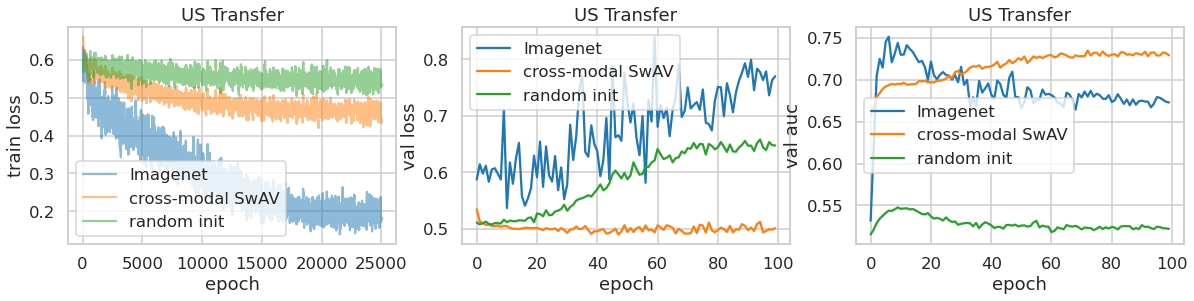

In [ ]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

model_path = 'us/20220411_us_latest.pth'
prefix = 'unfreeze_batch16'

learning_curves(save_path, model_path, prefix, 'US Transfer', '')

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/us/20220411_us_latest.pth/unfreeze_batch16/20220412_214906.log.json


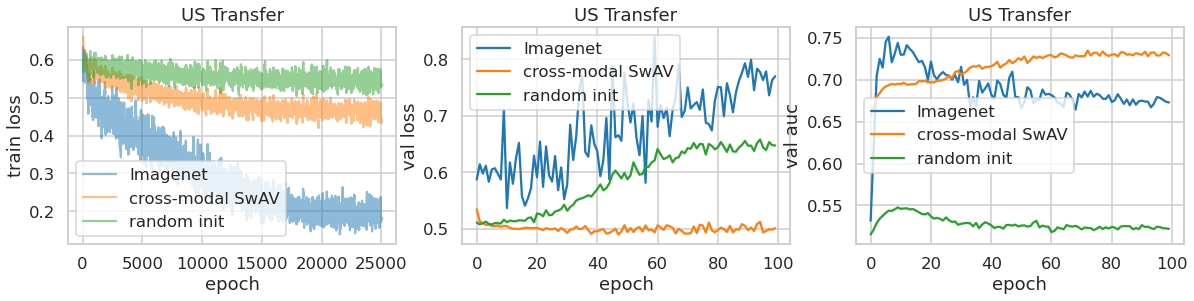

In [ ]:

learning_curves(save_path, model_path, prefix, 'US Transfer', '')

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/us/20220411_us_latest.pth/unfreeze_batch16/20220412_214906.log.json


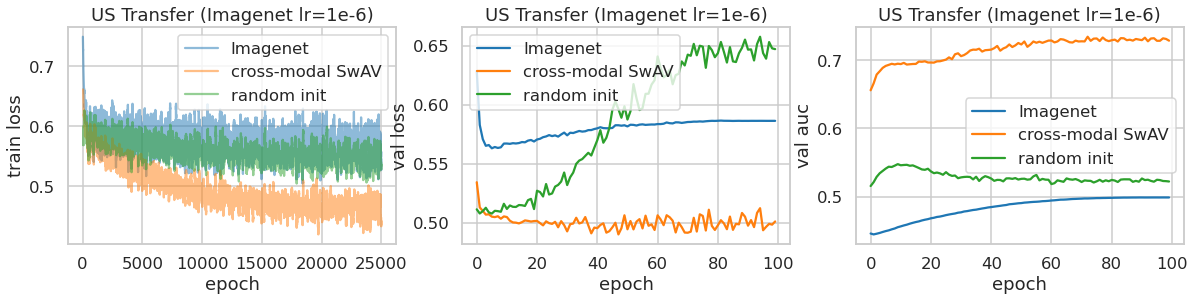

In [ ]:
learning_curves(save_path, model_path, prefix, 'US Transfer (Imagenet lr=1e-6)', '_lr1e6')

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/us/20220411_us_latest.pth/unfreeze_batch16/20220412_214906.log.json


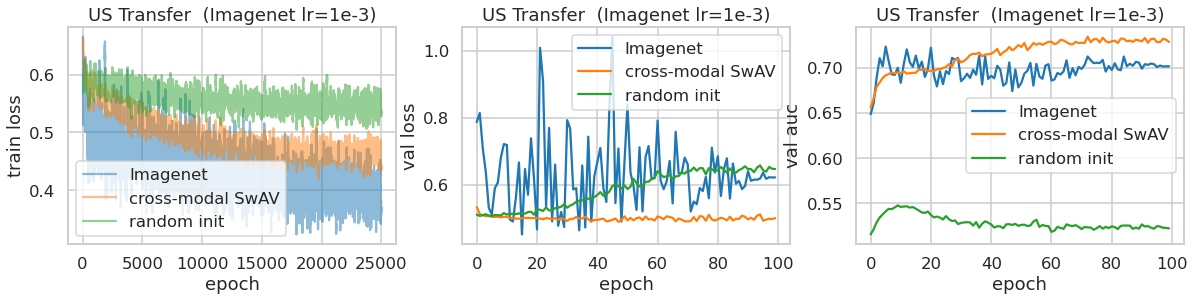

In [ ]:
learning_curves(save_path, model_path, prefix, 'US Transfer  (Imagenet lr=1e-3)', '_lr1e3')

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/us/20220411_us_latest.pth/balanced/20220412_130853.log.json


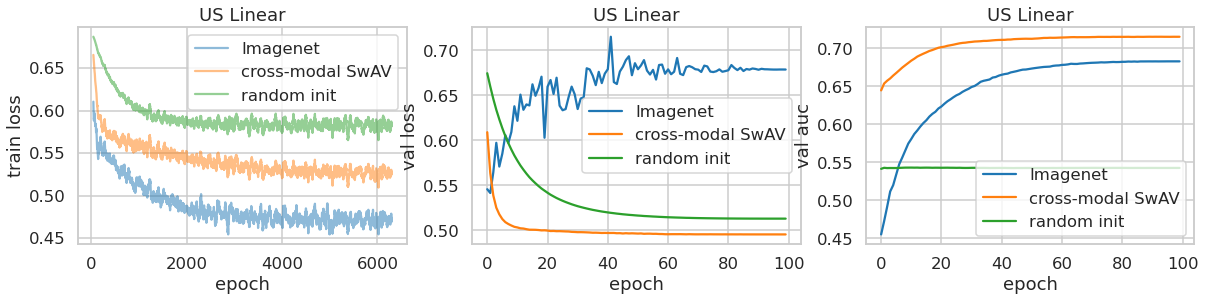

In [ ]:
prefix = 'balanced'
learning_curves(save_path, model_path, prefix, 'US Linear')

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/20220411_ffdm_latest.pth/locality_atten/20220420_194413.log.json


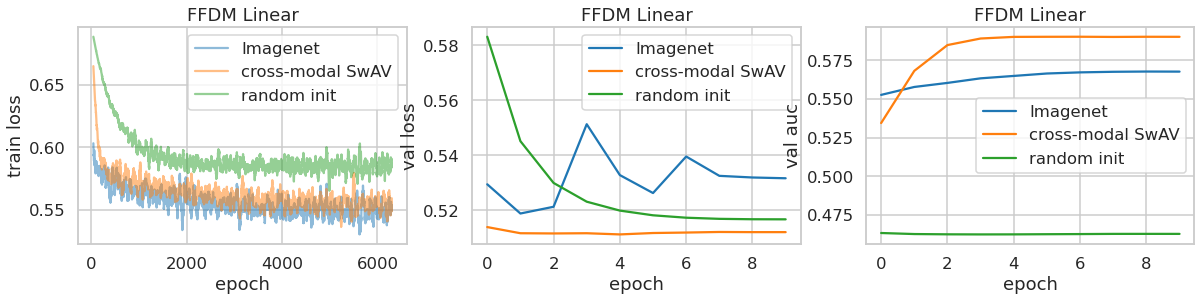

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm_fixed_datasampler/20220411_ffdm_latest.pth/locality_atten/20220421_140939.log.json


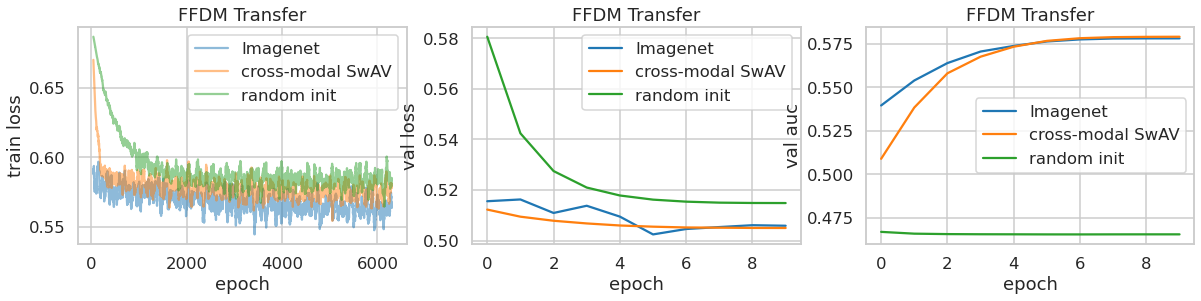

In [ ]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

model_path = 'ffdm/20220411_ffdm_latest.pth'
# prefix = 'unfreeze'

# learning_curves(save_path, model_path, prefix, 'FFDM Transfer')

# prefix = 'balanced'

# learning_curves(save_path, model_path, prefix, 'FFDM Linear')

prefix = 'locality_atten'

learning_curves(save_path, model_path, prefix, 'FFDM Linear')

model_path = 'ffdm_fixed_datasampler/20220411_ffdm_latest.pth'
prefix = 'locality_atten'

learning_curves(save_path, model_path, prefix, 'FFDM Transfer')




In [ ]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

model_path = ''

variants = ['ffdm/20220411_ffdm_latest.pth/locality_atten', 'ffdm/20220411_ffdm_latest.pth/locality_atten_imagenet', 
    'ffdm_fixed_datasampler/20220411_ffdm_latest.pth/locality_atten',
    'ffdm_fixed_datasampler/20220411_ffdm_latest.pth/locality_atten_imagenet', 
    'ffdm_highresolution.py/ffdm_latest.pth/locality_atten'
    ]

performance = []
for cls in variants:
    file = sorted(glob.glob(os.path.join(save_path, model_path, cls, '*.json')))[-1]
    
    f = open(file)
    lines = f.readlines()[1:]
    logs = pd.DataFrame([json.loads(line) for line in lines])
    
    print(file,'epoch' ,logs.epoch.max())
    if logs.epoch.max()>20:
    
        loss, auc = logs[logs['mode']=='val'].head4_loss.min(), logs[logs['mode']=='val'].head4_auc.max()
        performance.append({'datasample':  cls.split('/')[0], 'model': cls.split('/')[-1], 'loss': loss, 'auc': auc})
performance = pd.DataFrame(performance)
performance

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/20220411_ffdm_latest.pth/locality_atten/20220420_194413.log.json epoch 100
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/20220411_ffdm_latest.pth/locality_atten_imagenet/20220420_154300.log.json epoch 100
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm_fixed_datasampler/20220411_ffdm_latest.pth/locality_atten/20220421_140939.log.json epoch 100
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm_fixed_datasampler/20220411_ffdm_latest.pth/locality_atten_imagenet/20220421_141356.log.json epoch 100
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm_highresolution.py/ffdm_latest.pth/locality_atten/20220422_105023.log.json epoch 100


,datasample,model,loss,auc
0,ffdm,locality_atten,0.51121,0.59027
1,ffdm,locality_atten_imagenet,0.51882,0.56775
2,ffdm_fixed_datasampler,locality_atten,0.50497,0.57900
3,ffdm_fixed_datasampler,locality_atten_imagenet,0.50243,0.57807
4,ffdm_highresolution.py,locality_atten,0.50453,0.58517


/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/us/20220411_us_latest.pth/balanced/20220412_130853.log.json


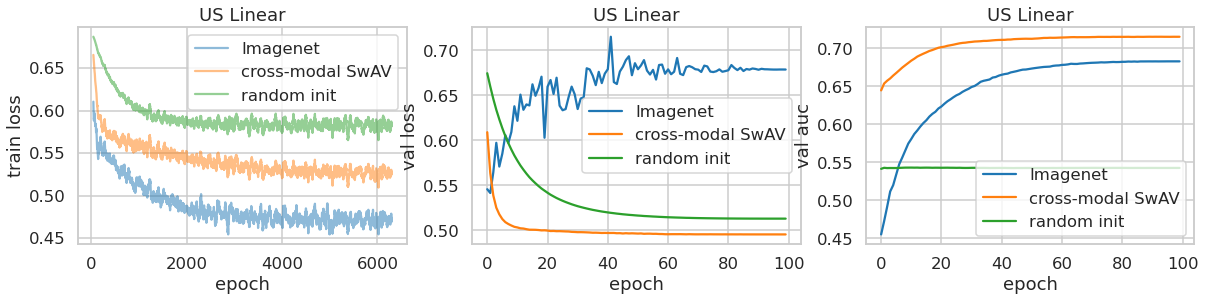

In [ ]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

model_path = 'us/20220411_us_latest.pth'

prefix = 'balanced'

learning_curves(save_path, model_path, prefix, 'US Linear')